In [2]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
# q1

In [4]:
# a

In [31]:
df=pd.read_csv("data/incomes.txt",names=['Income'])
df.describe()

,Income
count,200.000000
mean,85276.823606
std,18037.692869
min,47628.560636
25%,71850.308175
50%,83864.444560
75%,96059.995074
max,139079.351549


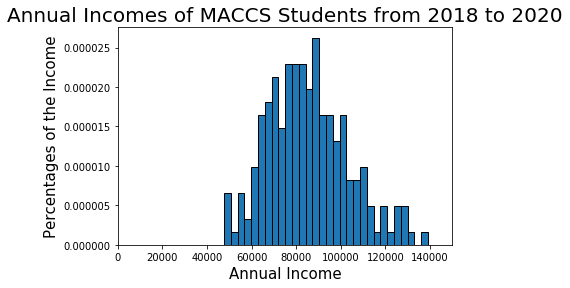

In [21]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed = True, edgecolor = 'k')
plt.xlabel('Annual Income', fontsize = 15)
plt.ylabel('Percentages of the Income', fontsize = 15)
plt.title('Annual Incomes of MACCS Students from 2018 to 2020', fontsize = 20)
plt.xlim([0, 150000])
plt.show()

In [ ]:
# b

In [29]:
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

def data_moments(xvals):

    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

def model_moments(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)

def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):

    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2) #Identity matrix
gmm_args = (df['Income'], 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mean_data, std_data = data_moments(df['Income'])
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(df['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard Deviation =', std_model)
print('Error vector=', err1)
print('GMM criterion function =',results.fun)



mu_GMM1= 11.333533482547043  sig_GMM1= 0.21386191435240656
Mean of points = 85276.82360625808 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82405894298 , Standard Deviation = 18037.692424757304
Error vector= [ 5.30841645e-09 -2.46491756e-08]
GMM criterion function = [[6.35761144e-16]]


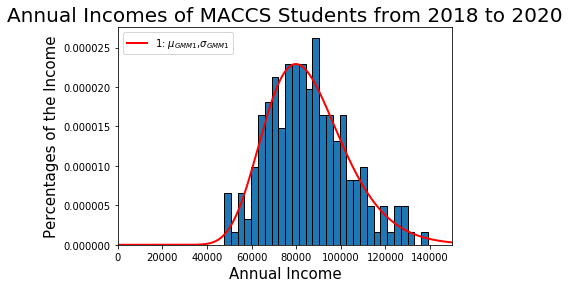

In [30]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed = True, edgecolor = 'k')
plt.xlabel('Annual Income', fontsize = 15)
plt.ylabel('Percentages of the Income', fontsize = 15)
plt.title('Annual Incomes of MACCS Students from 2018 to 2020', fontsize = 20)
plt.xlim([0, 150000])

dist_pts = np.linspace(0, 150000, 3000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

In [26]:
# c

In [34]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    
    return Err_mat

Err_mat =get_Err_mat2(df['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / df['Income'].shape[0]) * (Err_mat @ Err_mat.T)
print("VCV2 is",VCV2)
W_hat2 = lin.inv(VCV2)
print("W_hat2 is",W_hat2)

VCV2 is [[4.45167060e-02 1.67963797e+03]
 [1.67963797e+03 9.49413425e+08]]
W_hat2 is [[ 2.40701669e+01 -4.25833101e-05]
 [-4.25833101e-05  1.12861743e-09]]


In [35]:
gmm_args = (df['Income'], 0.0, 150000.0, W_hat2)
params_init = np.array([mu_GMM1, sig_GMM1])
results2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.333533472755567  sig_GMM2= 0.2138619137414848


In [60]:
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(df['Income'], mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model2, ', Standard Deviation of model =', std_model2)
print('Error vector=', err2)
print('GMM criterion function =',results2.fun)

Mean of points = 85276.82360625808 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82324668276 , Standard Deviation of model = 18037.692248481748
Error vector= [-4.21656562e-09 -3.44217977e-08]
GMM criterion function = [[4.27941383e-16]]


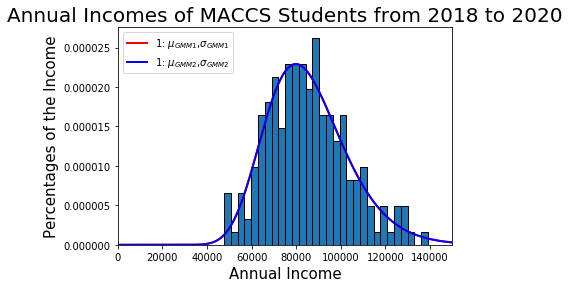

In [38]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed = True, edgecolor = 'k')
plt.xlabel('Annual Income', fontsize = 15)
plt.ylabel('Percentages of the Income', fontsize = 15)
plt.title('Annual Incomes of MACCS Students from 2018 to 2020', fontsize = 20)
plt.xlim([0, 150000])

dist_pts = np.linspace(0, 150000, 3000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='b', label='1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

plt.show()

In [ ]:
# d

In [40]:
# This function computes the three data moments for GMM (binpct_1, binpct_2, binpct_3).
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals <75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

# This function computes the three model moments for GMM (binpct_1, binpct_2, binpct_3).
def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

# This function computes the vector of moment errors (in percent deviation from the data moment vector) for GMM.

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val


In [61]:
W_hat1_3 = np.eye(3)
gmm_args = (df['Income'], 0.0, 150000.0, W_hat1_3)

results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
err3 = err_vec3(df['Income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False).reshape(3,)

bpct_1_dat, bpct_2_dat, bpct_3_dat=data_moments3(df['Income'])
pert1, pert2, pert3 = model_moments3(mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0)

print('Error vector=', err3)
print('GMM criterion function is',results_3.fun)
mm=pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Momets':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
mm

mu_GMM1_3= 11.336705162764714  sig_GMM1_3= 0.21151353494384018
Error vector= [ 1.61522336e-07 -7.19526515e-08 -6.24018733e-08]
GMM criterion function is [[3.51606427e-14]]


,Data Moments,Model Momets
Percent <75000,0.3,0.3
Percent 75000~100000,0.5,0.5
Percent >=100000,0.2,0.2


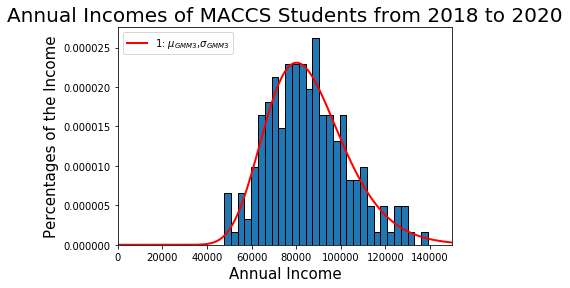

In [46]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed = True, edgecolor = 'k')
plt.xlabel('Annual Income', fontsize = 15)
plt.ylabel('Percentages of the Income', fontsize = 15)
plt.title('Annual Incomes of MACCS Students from 2018 to 2020', fontsize = 20)
plt.xlim([0, 150000])

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')

plt.show()

In [ ]:
# e

In [51]:
# This function computes the R x N matrix of errors from each observation for each moment.

def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

Err_mat3_1 = get_Err_mat3(df['Income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False)
VCV2_3_1 = (1 / df['Income'].shape[0]) * (Err_mat3_1 @ Err_mat3_1.T)
print("VCV2_3 is",VCV2_3_1)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3_1)
print("W_hat2_3 is",W_hat2_3)

VCV2_3 is [[ 2.33333258 -0.99999991 -0.9999999 ]
 [-0.99999991  1.00000014 -1.00000013]
 [-0.9999999  -1.00000013  4.0000005 ]]
W_hat2_3 is [[ 0.25761775 -0.14958453 -0.01246539]
 [-0.14958453  0.11911361 -0.07340718]
 [-0.01246539 -0.07340718  0.20221604]]


In [58]:
gmm_args = (df['Income'], 0.0, 150000.0, W_hat2_3)
results_4 = opt.minimize(criterion3, params_init, args=(gmm_args),method='L-BFGS-B')
mu_GMM1_3_1, sig_GMM1_3_1 = results_4.x
print('mu_GMM1_3_1=', mu_GMM1_3_1, ' sig_GMM1_3_1=', sig_GMM1_3_1)
err3_1 = err_vec3(df['Income'], mu_GMM1_3_1, sig_GMM1_3_1, 0.0, 150000.0, False).reshape(3,)

pert1, pert2, pert3 = model_moments3(mu_GMM1_3w, sig_GMM1_3_1, 0.0, 150000.0)

print('Error vector=', err3_1)
print('GMM criterion function is',results_4.fun)
mm=pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Momets':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
mm

mu_GMM1_3_1= 11.333533482547043  sig_GMM1_3_1= 0.21386191435240656
Error vector= [ 0.02420924 -0.01108994 -0.00858902]
GMM criterion function is [[0.00025207]]


,Data Moments,Model Momets
Percent <75000,0.3,0.307263
Percent 75000~100000,0.5,0.494455
Percent >=100000,0.2,0.198282


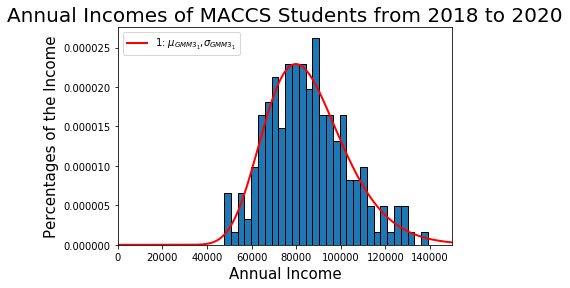

In [53]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed = True, edgecolor = 'k')
plt.xlabel('Annual Income', fontsize = 15)
plt.ylabel('Percentages of the Income', fontsize = 15)
plt.title('Annual Incomes of MACCS Students from 2018 to 2020', fontsize = 20)
plt.xlim([0, 150000])

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3_1, sig_GMM1_3_1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3_1}$,$\sigma_{GMM3_1}$')
plt.legend(loc='upper left')

plt.show()

In [54]:
# f

In [63]:
sigma = [sig_GMM1,sig_GMM2,sig_GMM1_3,sig_GMM1_3_1]
mu = [mu_GMM1,mu_GMM2,mu_GMM1_3,mu_GMM1_3_1]
GMM_value=[results.fun,results2.fun,results_3.fun,results_4.fun]

pd.DataFrame({"mu":mu,"sigma":sigma,"GMM Function Value":GMM_value}
            ,index=['2 moments+Identity Matrix','2 moments+Weighted Matrix',
                   '3 moments+Identity Matrix','3 moments+Weighted Matrix']).astype(float)

,mu,sigma,GMM Function Value
2 moments+Identity Matrix,11.333533,0.213862,6.357611e-16
2 moments+Weighted Matrix,11.333533,0.213862,4.279414e-16
3 moments+Identity Matrix,11.336705,0.211514,3.516064e-14
3 moments+Weighted Matrix,11.333533,0.213862,2.520739e-04


In [ ]:
# part (c) best fits the data because it has the smallest GMM function value. 
# In part (c), it uses the mean and std of the income to represents the two moments with two-step optimal weighting matrix.


In [ ]:
# q2

In [75]:
df=pd.read_csv("data/sick.txt").astype('float64')
df.describe()

,sick,age,children,avgtemp_winter
count,200.000000,200.000000,200.000000,200.000000
mean,1.008600,40.683850,1.674950,44.041250
std,0.504222,11.268686,0.969761,11.101977
min,0.040000,12.810000,0.000000,16.500000
25%,0.650000,33.967500,0.970000,36.112500
50%,0.960000,41.015000,1.560000,43.300000
75%,1.322500,47.750000,2.322500,52.172500
max,2.800000,74.890000,4.960000,68.600000


In [77]:
def err_vec(df,b0,b1,b2,b3):
    yhat=b0+b1*df['age']+b2*df['children']+b3*df['avgtemp_winter']
    y=df['sick']
    err_vec = yhat - y    
    
    return err_vec

def criterion(params, *args):
    b0,b1,b2,b3 = params
    df, W = args
    err = err_vec(df,b0,b1,b2,b3)
    crit_val = err.T @ W @ err
    
    return crit_val

b0, b1, b2, b3 = 1, 0, 0, 0
params_init = np.array([b0, b1, b2, b3])
W_hat = np.eye(df.shape[0])
gmm_args = (df, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,method='L-BFGS-B')
b0, b1, b2, b3 = results.x

print("b0 estimation is",b0)
print("b1 estimation is",b1)
print("b2 estimation is",b2)
print("b3 estimation is",b3)
print('GMM criterion function is',results.fun)

b0 estimation is 0.2516448636180223
b1 estimation is 0.012933469667256711
b2 estimation is 0.40050098511048643
b3 estimation is -0.009991708483433188
GMM criterion function is 0.00182128980560192
